### Importing Packagaes

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.applications import ResNet50, VGG16
import keras_tuner as kt
# import torch
# import torchvision
# import torchvision.transforms as transforms

### Loading and Splitting Data

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'og_data',
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(300, 500))

val_ds = tf.keras.utils.image_dataset_from_directory(
  'og_data',
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(300, 500))


Found 200 files belonging to 5 classes.
Using 140 files for training.
Found 200 files belonging to 5 classes.
Using 60 files for validation.


In [3]:
# Figuring out our classes for this dataset
class_names = train_ds.class_names
class_names


['ankylosaurus', 'brontosaurus', 'pterodactyl', 'trex', 'triceratops']

### Examples of Images and their Labels

2024-04-07 15:58:42.834116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


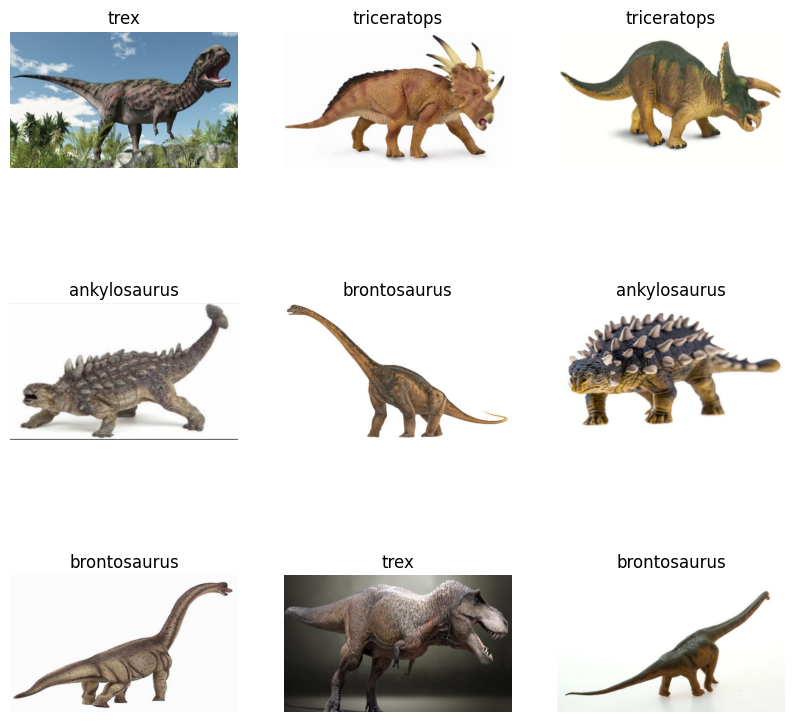

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Building the Model

In [4]:
# Adds more variation and data to the dataset by performing random transformations to the images
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (300, 500, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

/Users/calwinli/miniforge3/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# Adds more variation and data to the dataset by performing random transformations to the images
data_augmentation_demo = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

2024-04-07 16:00:36.076449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


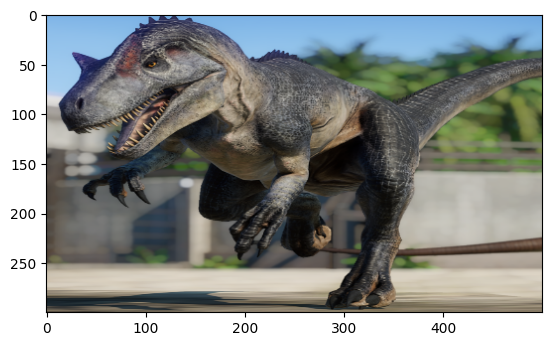

In [39]:
for images, _ in train_ds.take(1):
    image = images[0]

plt.imshow(image.numpy().astype("uint8"))
plt.show()

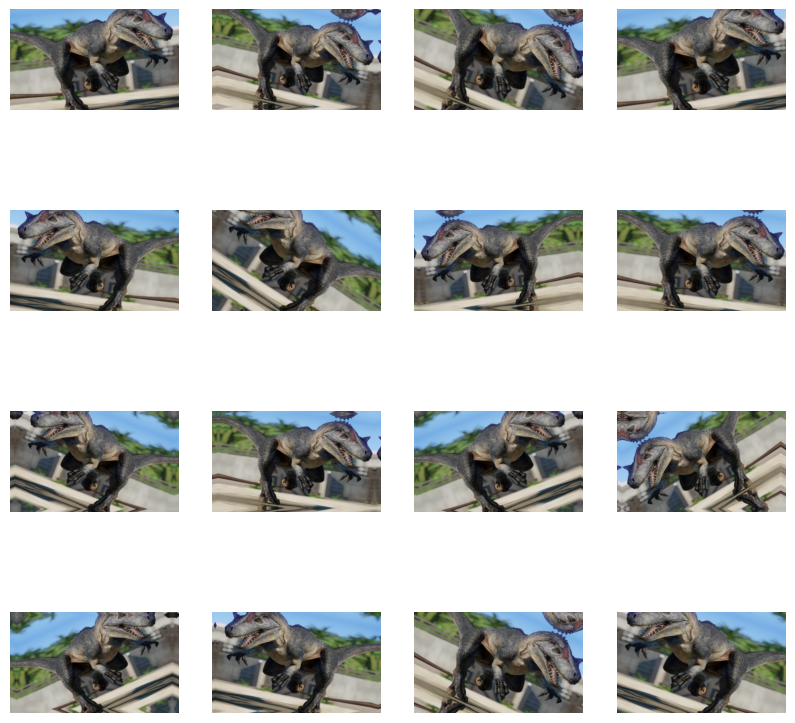

In [44]:
plt.figure(figsize = (10, 10))
for i in range(16):
    aug_image = data_augmentation_demo(image)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(aug_image.numpy().astype("uint8"))
    plt.axis("off")

In [5]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [6]:
def build_model(hp):
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape = (300, 500, 3)),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            input_shape = (300, 500, 3)
        ),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            activation = 'relu',
        ),
        layers.MaxPooling2D(),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            input_shape = (300, 500, 3)
        ),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(
            hp.Int('dense_layer1', min_value = 16, max_value = 128, step = 16),
            activation = 'relu'
        ),
        layers.Dropout(0.2),
        layers.Dense(5, activation = 'softmax')
    ])
    model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [7]:
tuner = kt.Hyperband(build_model,
objective = 'val_accuracy',
max_epochs = 15,
factor = 3,
directory = 'dir',
project_name = '5class_tuner_adam')

/Users/calwinli/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
tuner.search(train_ds, validation_data = val_ds, epochs = 15, callbacks = [stop_early])

Trial 30 Complete [00h 03m 26s]
val_accuracy: 0.7166666388511658

Best val_accuracy So Far: 0.8666666746139526
Total elapsed time: 01h 05m 48s


In [9]:
model = tuner.get_best_models(num_models = 1)[0]

In [27]:
model.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.8694 - loss: 0.5281


[0.5280689001083374, 0.8666666746139526]

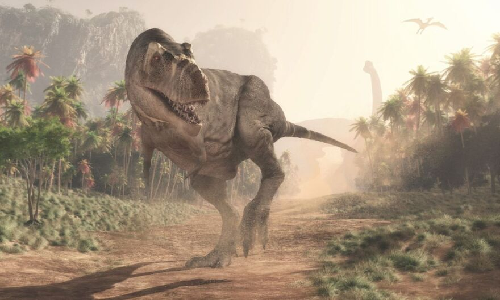

In [34]:
img

In [33]:
img = tf.keras.utils.load_img(
    'ttest.jpeg', target_size=(300, 500)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image most likely belongs to trex with a 40.45 percent confidence.


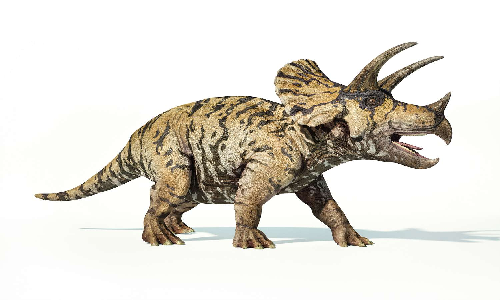

In [36]:
img

In [35]:
img = tf.keras.utils.load_img(
    'tritest.jpeg', target_size=(300, 500)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to triceratops with a 39.53 percent confidence.
